In [134]:
from fitparse import FitFile
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import pandas as pd
import os

In [231]:
folder = "/Users/benho/Documents/workspace/garmin/data"
data_files = os.listdir(folder)[:1]
print(data_files)

['14apr2025_NationalSelections_k1_1000m_final.FIT']


In [232]:
def load_data(file_path):
    # Load the .FIT file
    fitfile = FitFile(file_path)

    # Prepare lists for data
    full_data = []

    # Extract data from "record" messages
    for record in fitfile.get_messages("record"):
        data = {d.name: d.value for d in record}
        speed = data.get("speed")
        full_data.append(data)

    df = pd.DataFrame(full_data)

    # Get the reference start time
    start_time = df["timestamp"].iloc[0]

    # Apply to compute seconds since start
    df["time_seconds"] = df["timestamp"].apply(lambda x: (x - start_time).total_seconds())
    df['pace'] = df['enhanced_speed'].apply(lambda x: 1000 / (x * 60) if x > 0 else 0.0)
    df['speed'] = df['enhanced_speed'].apply(lambda x: x * 3.6)

    return df

In [233]:
data = [(file, load_data(folder + "/" + file)) for file in data_files]
df = data[0][1]
df.head()

,distance,distance_per_stroke,enhanced_altitude,enhanced_speed,heart_rate,position_lat,position_long,stroke_cadence,stroke_counter,temperature,timestamp,time_seconds,pace,speed
0,0.00,3.098730,2.6,3.305,None,15507324,1239224435,64,1,32,2025-04-14 10:10:15,0.0,5.042864,11.8980
1,3.02,2.860938,2.6,3.290,None,15507258,1239224117,69,3,32,2025-04-14 10:10:16,1.0,5.065856,11.8440
2,5.75,2.670315,2.6,3.249,None,15507184,1239223834,73,4,32,2025-04-14 10:10:17,2.0,5.129784,11.6964
3,8.34,1.824649,2.6,3.193,None,15507130,1239223630,105,5,32,2025-04-14 10:10:18,3.0,5.219752,11.4948
4,10.58,1.774517,2.6,3.105,None,15507072,1239223424,105,5,32,2025-04-14 10:10:19,4.0,5.367687,11.1780


In [234]:
def extract_race_segment(df):
    """
    Function for extracting race segments from speed data.

    Returns:
    - race_segment_df: DataFrame containing the race segment (all columns), or
    - None if no high-speed segment is found
    """
    # Set thresholds
    high_speed_thresh = df['speed'].quantile(0.9)
    low_speed_thresh = 1e-2  # Define what "not moving" means (can tweak this)

    # Mask for high speed
    mask = df['speed'] > high_speed_thresh
    if not mask.any():
        return None  # No high-speed data at all

    group_ids = (mask != mask.shift()).cumsum()
    df = df.copy()
    df['group'] = group_ids
    df['above'] = mask

    # Group segments and check if any exist
    segments = df[df['above']].groupby('group')
    if segments.ngroups == 0:
        return None

    # Find longest high-speed segment
    longest_segment = max(segments, key=lambda x: len(x[1]))[1]

    # Get index range of the high-speed segment
    start_idx = longest_segment.index[0]
    end_idx = longest_segment.index[-1]

    # Extend backward to race start
    while start_idx > 0 and df.loc[start_idx - 1, 'speed'] > low_speed_thresh:
        start_idx -= 1

    # Extend forward to race end
    while end_idx < len(df) - 1 and df.loc[end_idx + 1, 'speed'] > low_speed_thresh:
        end_idx += 1

    # Extract full race segment
    race_segment_df = df.loc[start_idx:end_idx].reset_index(drop=True)
    return race_segment_df

In [235]:
def extract_interval_segment(df, speed_col='speed', min_peaks=3):
    """
    Extracts a segment of interval training based on alternating high and low speed patterns.

    Parameters:
    - df: pandas DataFrame containing the speed/time data
    - speed_col: name of the column with speed data
    - min_peaks: minimum number of peaks and valleys to qualify as interval training
    - high_thresh: minimum speed to count as a peak
    - low_thresh: maximum speed to count as a valley
    - smooth_window: size of the rolling window used to smooth speed data

    Returns:
    - interval_segment_df: DataFrame containing the interval training segment (all columns)
    - or None if no interval pattern is found
    """
    # Copy to avoid modifying original
    df = df.copy()

    # Detect peaks (high intensity)
    peaks, _ = find_peaks(df['speed'], height=df['speed'].quantile(0.99))

    # Detect valleys (low intensity)
    valleys, _ = find_peaks(-df['speed'], height=-df['speed'].quantile(0.2))

    # If sufficient alternating peaks and valleys found
    if len(peaks) >= min_peaks and len(valleys) >= min_peaks:
        start_idx = min(peaks[0], valleys[0])
        end_idx = max(peaks[-1], valleys[-1])
        # return df.loc[start_idx:end_idx].drop(columns=['speed_smooth']).reset_index(drop=True)
        return df.loc[start_idx:end_idx].reset_index(drop=True)
    
    return None  # No interval segment found

In [236]:
race_segment = extract_race_segment(df)
interval_segment = extract_interval_segment(df)
race_segment.head()

,distance,distance_per_stroke,enhanced_altitude,enhanced_speed,heart_rate,position_lat,position_long,stroke_cadence,stroke_counter,temperature,timestamp,time_seconds,pace,speed,group,above
0,2818.47,0.017179,4.4,0.027,None,15326787,1239212488,95,768,28,2025-04-14 10:40:14,1799.0,617.283951,0.0972,5,False
1,2822.91,0.160291,4.4,0.307,None,15327324,1239212308,115,770,28,2025-04-14 10:40:15,1800.0,54.288817,1.1052,5,False
2,2827.80,0.422319,4.6,0.859,None,15327892,1239212113,122,772,28,2025-04-14 10:40:16,1801.0,19.402406,3.0924,5,False
3,2832.99,0.611217,4.6,1.284,None,15328468,1239211913,126,775,28,2025-04-14 10:40:17,1802.0,12.980270,4.6224,5,False
4,2838.32,0.805993,4.8,1.719,None,15329027,1239211714,128,777,28,2025-04-14 10:40:18,1803.0,9.695559,6.1884,5,False


In [237]:
interval_segment.head()

AttributeError: 'NoneType' object has no attribute 'head'

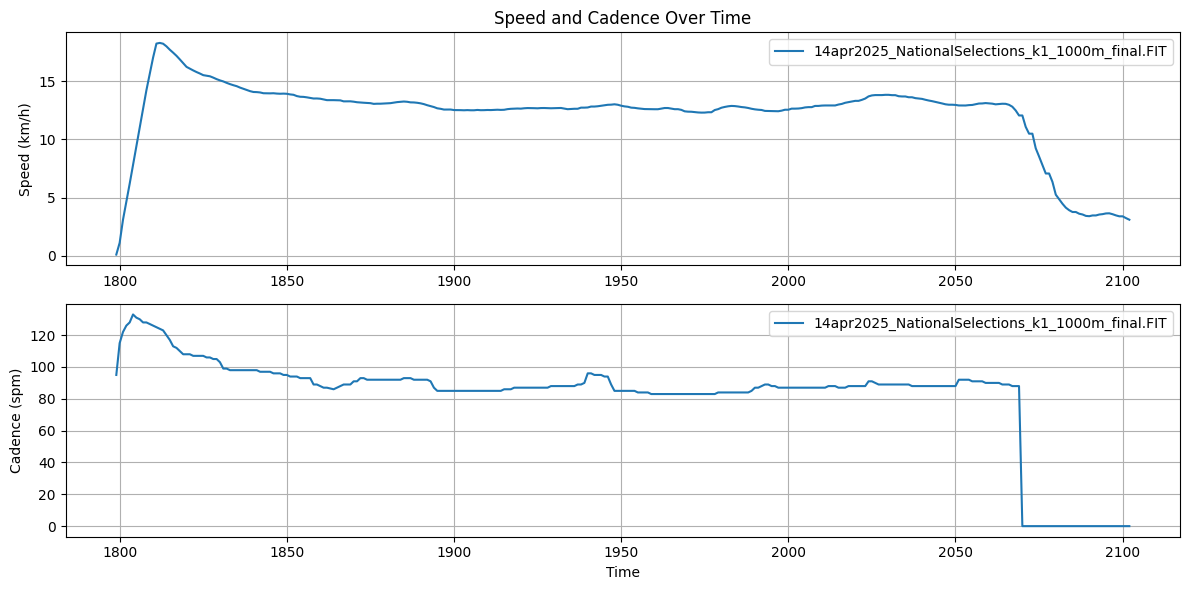

In [238]:
# Plotting
plt.figure(figsize=(12, 6))

# Plot speed
plt.subplot(2, 1, 1)
for file, df in data:
    plt.plot(race_segment['time_seconds'], race_segment['speed'], label=file)
    plt.ylabel("Speed (km/h)")
    plt.title("Speed and Cadence Over Time")
    plt.grid(True)
    plt.legend()

# Plot heart rate
plt.subplot(2, 1, 2)
for file, df in data:
    plt.plot(race_segment['time_seconds'], race_segment['stroke_cadence'], label=file)
    plt.xlabel("Time")
    plt.ylabel("Cadence (spm)")
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

TypeError: 'NoneType' object is not subscriptable

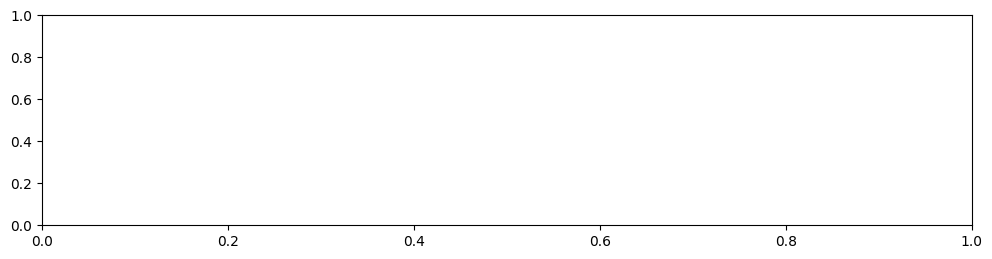

In [239]:
# Plotting
plt.figure(figsize=(12, 6))

# Plot speed
plt.subplot(2, 1, 1)
for file, df in data:
    plt.plot(interval_segment['time_seconds'], interval_segment['speed'], label=file)
    plt.ylabel("Speed (km/h)")
    plt.title("Speed and Cadence Over Time")
    plt.grid(True)
    plt.legend()

# Plot heart rate
plt.subplot(2, 1, 2)
for file, df in data:
    plt.plot(interval_segment['time_seconds'], interval_segment['stroke_cadence'], label=file)
    plt.xlabel("Time")
    plt.ylabel("Cadence (spm)")
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()